# <center> üèôÔ∏è O L I M P O üèôÔ∏è </center>

### <center> An√°lises de Dados </center>
 

## 0. Configura√ß√µes e Vari√°veis

### 0.1 Importa√ß√µes

In [1]:
import os
import re
import joblib

import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.pipeline import Pipeline

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

# Ignorar avisos espec√≠ficos do Scikit-Learn
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', message="X does not have valid feature names")
warnings.filterwarnings(action='ignore', message="One or more of the test scores are non-finite")

### 0.2 Classificadores e Pr√©-Processadores

In [3]:
os.environ["PATH"] += os.pathsep + 'C:\\Users\\sofiadomingues-ieg\\OneDrive - Instituto Germinare\\2024\\Analise de Dados\\Arvore de Decisao\\Graphviz-11.0.0-win64\\bin'

In [4]:
classificador_tree = tree.DecisionTreeClassifier()
classificador_gauss = GaussianNB()
classificador_knn = KNeighborsClassifier()
zscore = StandardScaler()
smote = SMOTE()

In [5]:
# Pr√©-processador para transformar os atributos
preprocessador = ColumnTransformer(
    transformers=[
        ('categoricas', OrdinalEncoder(), make_column_selector(dtype_include=['object']))
    ],
    remainder='passthrough', 
    verbose_feature_names_out = False   
)

## 1. Pr√©-Processamento dos Dados 

A base tem 20 colunas, sendo dessas:
- 12 pertencem a X (outras)
- 1 pertence a Y (implementa_app)
- 6 n√£o possuem relev√¢nca para a X ('ID', 'Hora de in√≠cio', 'Hora de conclus√£o', 'Email', 'Nome', 'Termo de Anonimato', 'Nivel de Satisfa√ß√£o com a Plataforma Utilizada')

Al√©m disso, a Y est√° desbalanceada, composta por:
- 75 <= SIM (classe majorit√°ria)
- 18 >= N√ÉO (classe minorit√°ria)

In [6]:
df_olimpo = pd.read_excel("Olimpo.xlsx")

### 1.1 Tratamento

#### 1.1.1 Renomear colunas

In [7]:
df_olimpo = df_olimpo.rename(columns={
    'ID': 'id',
    'Hora de in√≠cio': 'inicio',
    'Hora de conclus√£o': 'conclusao',
    'Termo de Anonimato\xa0': 'anonimato',
    'Em que cidade voc√™ vive atualmente?': 'cidade',
    'Qual √© seu tipo da sua moradia?': 'tipo_moradia',
    'Com quantas pessoas voc√™ divide sua casa/apartamento?': 'pessoas_casa',
    'Qual √© o seu n√≠vel de satisfa√ß√£o com a comunica√ß√£o dentro da comunidade em que voc√™ vive?\nEssa comunidade pode ser seu condom√≠nio, bairro ou a\xa0vizinhan√ßa em geral.\n': 'satisfacao_comunicacao_comunidade',
    'Com que frequ√™ncia voc√™ entra em contato com as pessoas que vivem pr√≥ximas a voc√™?\n\n': 'frequencia_contato',
    'Voc√™ acredita que a comunica√ß√£o entre a comunidade seja importante?': 'comunicacao_importante',
    'Voc√™ utiliza alguma plataforma direcionada a gest√£o e comunica√ß√£o do bairro ou condom√≠nio/pr√©dio em que vive?': 'usa_plataforma',
    'Qual √© o seu n√≠vel de satisfa√ß√£o com essa plataforma?': 'satisfacao_plataforma',
    'Em qual faixa et√°ria em que voc√™ se encontra atualmente?': 'faixa_etaria',
    'Qual dessas op√ß√µes representa mais a sua qualidade de vida atual?': 'qualidade_vida',
    'Qual √© a sua situa√ß√£o no mercado de trabalho?': 'situacao_trabalho',
    'Em qual renda familiar mensal voc√™ se encontra?\xa0\nAs faixas representam:\nClasse A - superior a R$ 28,2 mil\nClasse B -\xa0entre R$ 14,1 mil e R$ 28,2 mil\nClasse C -\xa0entre R$ 5,6 mil e R$ 14,1 mil\nClass...': 'renda_familiar',
    'Voc√™ possui animais de estima√ß√£o?': 'animais',
    'Voc√™ implementaria nosso aplicativo em sua rotina?': 'implementa_app'
})

#### 1.1.2 Extrair cidades da coluna cidade

In [8]:
siglas_estados = [
    'AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 
    'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO'
]

nomes_estados = [
    'Acre', 'Alagoas', 'Amap√°', 'Amazonas', 'Bahia', 'Cear√°', 'Distrito Federal', 'Esp√≠rito Santo', 
    'Goi√°s', 'Maranh√£o', 'Mato Grosso', 'Mato Grosso do Sul', 'Minas Gerais', 'Par√°', 'Para√≠ba', 
    'Paran√°', 'Pernambuco', 'Piau√≠', 'Rio de Janeiro', 'Rio Grande do Norte', 'Rio Grande do Sul', 
    'Rond√¥nia', 'Roraima', 'Santa Catarina', 'S√£o Paulo', 'Sergipe', 'Tocantins'
]

def extrair_cidade(valor):
    valor = valor.strip()
    for sigla in siglas_estados:
        if re.search(fr'[\s,.-]+{sigla}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{sigla}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    for nome in nomes_estados:
        if re.search(fr'[\s,.-]+{nome}\s*$', valor, re.IGNORECASE):
            valor = re.sub(fr'[\s,.-]+{nome}\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    valor = re.sub(r'[\s,.-]+capital\s*$', '', valor, flags=re.IGNORECASE).strip()
    
    return valor.title()

df_olimpo['cidade'] = df_olimpo['cidade'].apply(extrair_cidade)

# for i in range(0, len(df_olimpo) -1):
#     if df_olimpo['cidade'][i] not in ['Osasco', 'S√£o Paulo']:
#         df_olimpo.loc[i, 'cidade'] = 'Outros'

#### 1.1.3 Extra√ß√£o das op√ß√µes

In [9]:
df_olimpo['frequencia_contato'] = df_olimpo['frequencia_contato'].str.replace(r'\s*\(.*\)', '', regex=True)

### 1.2 Limpeza

#### 1.2.1 Remover colunas indesejadas

In [10]:
df_olimpo = df_olimpo.drop(columns=['id', 'inicio', 'conclusao', 'Email', 'Nome', 'anonimato', 'satisfacao_plataforma'], axis=1)

In [11]:
df_olimpo.to_excel('Olimpo_cleaned.xlsx')

## 2. Fun√ß√µes

In [12]:
def validacao_cross(atributos_treino, resposta_treino, atributos_teste, resposta_teste):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    f1_scores = []
    melhor_modelo = None
    melhor_f1_score = -1

    atributos_treino = pd.DataFrame(atributos_treino)
    resposta_treino = pd.DataFrame(resposta_treino)
    
    for fold_index, (train_index, val_index) in enumerate(kf.split(atributos_treino)):
        X_fold_train, X_fold_val = atributos_treino.iloc[train_index], atributos_treino.iloc[val_index]
        y_fold_train, y_fold_val = resposta_treino.iloc[train_index], resposta_treino.iloc[val_index]
    
        classificador_gauss.fit(X_fold_train, y_fold_train)
    
        y_pred = classificador_gauss.predict(X_fold_val)
    
        f1 = f1_score(y_fold_val, y_pred, average='macro')
        f1_scores.append(f1)
        print(f"Fold {fold_index + 1} - F1 Score: {f1:.4f}")
        if f1 > melhor_f1_score:
            melhor_f1_score = f1
            melhor_modelo = classificador_gauss

    predicao = melhor_modelo.predict(atributos_teste)   
    print('====> Valida√ß√£o Cross para Gaussian')
    print(classification_report(resposta_teste, predicao)) 

In [13]:
def separar_teste(atributos, resposta):
    df_atributos_treino, df_atributos_teste, df_resposta_treino, df_resposta_teste = train_test_split(atributos, resposta, test_size=0.2, random_state=0)

    atributos_treino = df_atributos_treino.values
    resposta_treino = df_resposta_treino
        
    atributos_teste = df_atributos_teste.values
    resposta_teste = df_resposta_teste

    return atributos_treino, atributos_teste, resposta_treino, resposta_teste

In [14]:
def plotar_matriz_conf(resposta_teste, classificacao):
    matriz_de_confusao = confusion_matrix(resposta_teste, classificacao)
    ConfusionMatrixDisplay(matriz_de_confusao).plot()
    plt.grid(False)
    plt.show()

In [15]:
def plotar_arvore(classificador, atributos_treino, grid):
    plt.figure(figsize=(30,7))
    tree.plot_tree(classificador,
                feature_names=atributos_treino.columns,
                class_names=['N√£o', 'Sim'],
                filled=True)
    plt.title(F"Crit√©rio {str(grid.best_estimator_)}", fontsize=16)
    plt.show()

    # Arvore com zoom (n√£o vou prolongar)

    # arvore = tree.export_graphviz(classificador, feature_names=atributos.columns,
    #                     class_names=classificador.classes_, filled=True)
        
    # graph = graphviz.Source(arvore, format='png')
    # graph

In [16]:
def classificador_hyperparametros(classificador, atributos_treino, atributos_teste, resposta_treino, resposta_teste, parametros):    
    
    # Essa fun√ß√£o foi implementada para evitar repeti√ß√£o de c√≥digo na hora de testar os parametros

    if isinstance(classificador, tree.DecisionTreeClassifier):
        grid = GridSearchCV(
                            estimator = classificador, 
                            param_grid = parametros['tree'], 
                            scoring = 'f1', 
                            n_jobs = -1
                        )
        
        grid.fit(atributos_treino, resposta_treino)
        
        print(grid.best_params_) # Mostrando os melhores parametros

        classificador = tree.DecisionTreeClassifier(**grid.best_params_)

    elif isinstance(classificador, KNeighborsClassifier):  
        grid = GridSearchCV(
                            estimator = classificador, 
                            param_grid = parametros['knn'], 
                            scoring = 'f1', 
                            n_jobs = -1
                        )
        grid.fit(atributos_treino, resposta_treino)
        
        print(grid.best_params_) # Mostrando os melhores parametros
        
        classificador = KNeighborsClassifier(**grid.best_params_)

    # Ajustando o modelo com os dados de treino e fazendo as previs√µes
    classificador.fit(atributos_treino, resposta_treino)
    classificacao = classificador.predict(atributos_teste)    

    # Relat√≥rio de classifica√ß√£o
    print(f"---> Relat√≥rio de Classifica√ß√£o: ")
    reporte_de_classificacao = classification_report(resposta_teste, classificacao)
    print(reporte_de_classificacao)
    
    # Plotando a matriz de confus√£o para entender os chutes do modelo
    plotar_matriz_conf(resposta_teste, classificacao)      

    # Aplicando a valida√ß√£o cross na Gaussiana para ter uma an√°lise maior dos resultados
    validacao_cross(atributos_treino, resposta_treino, atributos_teste, resposta_teste)

    return classificador

## 3. Testando os Modelos

√â importante entender daqui para frente que o meu foco √© encontrar o modelo com o melhor balanceamento entre os dados, ou seja, eu quero encontrar o modelo com o maior F1-Score, uma vez que essa m√©trica explica esse meu conjunto de dados baseado no balanceamentro entre as predi√ß√µes dos testes baseado no treino.

In [17]:
# Separando a coluna Y (resposta) das colunas X (atributos)
atributos = df_olimpo.iloc[:, :-1]
resposta = df_olimpo.iloc[:, -1:]

In [18]:
# Transformando os atributos qualitativos em quantitativos
atributos = pd.DataFrame(data=preprocessador.fit_transform(atributos), columns=preprocessador.get_feature_names_out())

In [19]:
# Normalizando os dados dos atributos
zscore.fit(atributos)
atributos_norm = zscore.transform(atributos)
atributos = pd.DataFrame(data = atributos_norm, columns=atributos.columns)

In [20]:
# Separando treino e teste
atributos_treino, atributos_teste, resposta_treino, resposta_teste = separar_teste(atributos, resposta)

In [21]:
# Instanciando o Smote
smote = SMOTE(k_neighbors = 5, random_state = 42) 
atributos_smote, resposta_smote = smote.fit_resample(atributos_treino, resposta_treino)

In [22]:
# Instanciando o Random Oversampling
random_oversample = RandomOverSampler(random_state=42)
atributos_ros, resposta_ros = random_oversample.fit_resample(atributos_treino, resposta_treino)
atributos_ros = pd.DataFrame(data=atributos_ros, columns=atributos.columns)

In [23]:
# Os parametros para cada modelo foram colocados nesse dict para facilitar 
modelos_parametros = {
    'tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None, 2, 4, 6, 8, 10, 12],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 5, 10],
        'max_features': [None, 'sqrt', 'log2']
    },
    'knn': { 
        'n_neighbors': range(2, (len(resposta_treino)//2)+1), 
        'weights': ['uniform', 'distance'], 
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
}

### 3.1 Gaussian

#### 3.1.1 Sem ajustes

-----------------------------------------------------
===> Gaussian sem ajustes
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       1.00      0.17      0.29         6
         Sim       0.72      1.00      0.84        13

    accuracy                           0.74        19
   macro avg       0.86      0.58      0.56        19
weighted avg       0.81      0.74      0.66        19



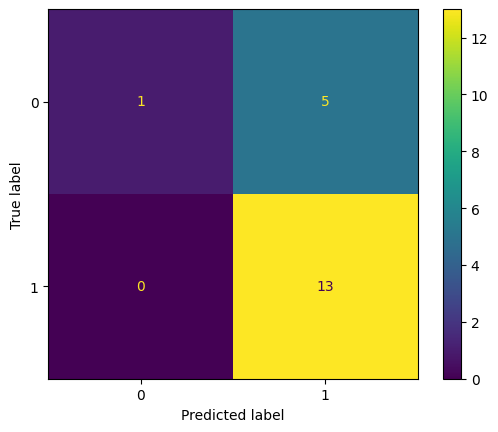

Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.50      0.17      0.25         6
         Sim       0.71      0.92      0.80        13

    accuracy                           0.68        19
   macro avg       0.60      0.54      0.53        19
weighted avg       0.64      0.68      0.63        19



GaussianNB()

In [24]:
print('-----------------------------------------------------')

print('===> Gaussian sem ajustes')

classificador_hyperparametros(classificador_gauss, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.1.2 Gaussian com SMOTE

-----------------------------------------------------
===> Gaussian com SMOTE
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



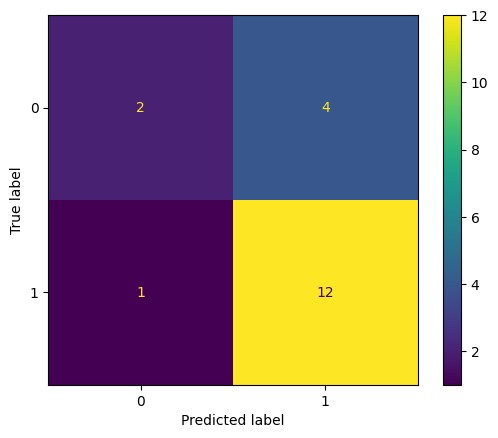

Fold 1 - F1 Score: 0.7565
Fold 2 - F1 Score: 0.7500
Fold 3 - F1 Score: 0.7182
Fold 4 - F1 Score: 0.6667
Fold 5 - F1 Score: 0.7884
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



In [25]:
print('-----------------------------------------------------')

print('===> Gaussian com SMOTE')

model = classificador_hyperparametros(classificador_gauss, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros)

#### 3.1.3 Gaussian com ROS

-----------------------------------------------------
===> Gaussian com Random Oversampling
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.50      0.33      0.40         6
         Sim       0.73      0.85      0.79        13

    accuracy                           0.68        19
   macro avg       0.62      0.59      0.59        19
weighted avg       0.66      0.68      0.66        19



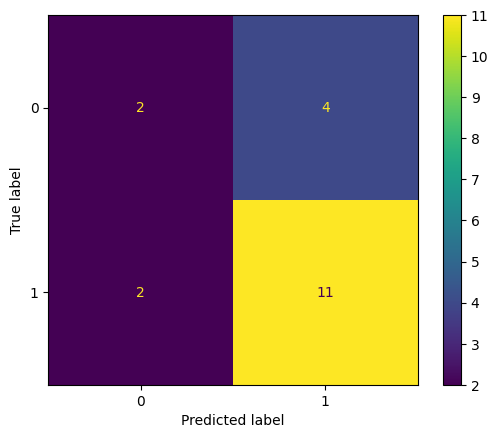

Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.60      0.50      0.55         6
         Sim       0.79      0.85      0.81        13

    accuracy                           0.74        19
   macro avg       0.69      0.67      0.68        19
weighted avg       0.73      0.74      0.73        19



GaussianNB()

In [26]:
print('-----------------------------------------------------')

print('===> Gaussian com Random Oversampling')

classificador_hyperparametros(classificador_gauss, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### 3.1 Considera√ß√µes sobre a Gaussiana

#### An√°lise das M√©tricas do Classificador Gaussiano

1. Gaussian Sem Ajustes (Somente Hiperpar√¢metros Padr√£o)
- **Classe "N√£o"**:
  - **Precision**: 1.00
  - **Recall**: 0.17
  - **F1-Score**: 0.29
  - A precis√£o √© alta, mas o recall √© muito baixo, indicando que a maioria dos exemplos da classe "N√£o" n√£o est√° sendo identificada corretamente.
  
- **Classe "Sim"**:
  - **Precision**: 0.72
  - **Recall**: 1.00
  - **F1-Score**: 0.84
  - A classe "Sim" est√° sendo identificada com alta efici√™ncia, com recall de 100%.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.74
  - **Macro avg** (m√©dia entre as classes): F1-Score de 0.56, indicando um desempenho desbalanceado entre as classes.
  
- **Conclus√£o**: O modelo est√° altamente enviesado para a classe "Sim", falhando em detectar corretamente a classe "N√£o".

---

2. Gaussian com SMOTE
- **Classe "N√£o"**:
  - **Precision**: 0.67
  - **Recall**: 0.33
  - **F1-Score**: 0.44
  - O recall teve uma leve melhoria (de 0.17 para 0.33), mas ainda est√° baixo. A precis√£o e o F1-Score tamb√©m melhoraram em rela√ß√£o ao modelo sem ajustes.
  
- **Classe "Sim"**:
  - **Precision**: 0.75
  - **Recall**: 0.92
  - **F1-Score**: 0.83
  - A classe "Sim" manteve um bom desempenho, com uma ligeira diminui√ß√£o na precis√£o em compara√ß√£o com o modelo inicial.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.74 (sem altera√ß√£o)
  - **Macro avg**: F1-Score de 0.64, representando uma melhoria em rela√ß√£o ao modelo inicial.
  
- **Conclus√£o**: O uso do SMOTE ajudou a melhorar o equil√≠brio entre as classes, embora a classe "N√£o" ainda tenha um recall baixo. A distribui√ß√£o est√° mais equilibrada em rela√ß√£o ao modelo inicial.

---

3. Gaussian com Random Oversampling
- **Classe "N√£o"**:
  - **Precision**: 0.50
  - **Recall**: 0.33
  - **F1-Score**: 0.40
  - A precis√£o diminuiu em compara√ß√£o com o modelo com SMOTE, mas o recall e o F1-Score da classe "N√£o" permanecem similares.
  
- **Classe "Sim"**:
  - **Precision**: 0.73
  - **Recall**: 0.85
  - **F1-Score**: 0.79
  - Houve uma leve redu√ß√£o no desempenho da classe "Sim", mas o F1-Score permanece razo√°vel.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.68, ligeiramente inferior aos outros modelos.
  - **Macro avg**: F1-Score de 0.59, refletindo uma leve piora em rela√ß√£o ao modelo com SMOTE.
  
- **Conclus√£o**: O Random Oversampling conseguiu melhorar um pouco o recall da classe "N√£o" em compara√ß√£o com o modelo sem ajustes, mas n√£o trouxe o mesmo equil√≠brio que o SMOTE proporcionou.

---

Resumo
1. **Gaussian Sem Ajustes**: Alta precis√£o para a classe "N√£o", mas com recall muito baixo, resultando em um modelo enviesado para a classe "Sim".
2. **Gaussian com SMOTE**: Melhorou o equil√≠brio entre as classes, com um leve aumento no F1-Score para a classe "N√£o" e um bom resultado geral.
3. **Gaussian com Random Oversampling**: Apresentou um desempenho intermedi√°rio, mas inferior ao SMOTE em termos de equil√≠brio entre as classes.


### 3.2 Tree Decision

#### 3.2.1 Sem ajustes

-----------------------------------------------------
===> Tree Decision
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.40      0.33      0.36         6
         Sim       0.71      0.77      0.74        13

    accuracy                           0.63        19
   macro avg       0.56      0.55      0.55        19
weighted avg       0.62      0.63      0.62        19



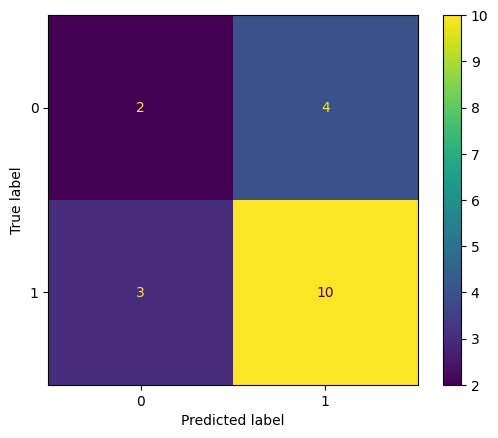

Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.50      0.17      0.25         6
         Sim       0.71      0.92      0.80        13

    accuracy                           0.68        19
   macro avg       0.60      0.54      0.53        19
weighted avg       0.64      0.68      0.63        19



DecisionTreeClassifier()

In [27]:
print('-----------------------------------------------------')

print('===> Tree Decision')

classificador_hyperparametros(classificador_tree, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.2.2 Com SMOTE

-----------------------------------------------------
===> Tree Decision com SMOTE
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.67      0.67      0.67         6
         Sim       0.85      0.85      0.85        13

    accuracy                           0.79        19
   macro avg       0.76      0.76      0.76        19
weighted avg       0.79      0.79      0.79        19



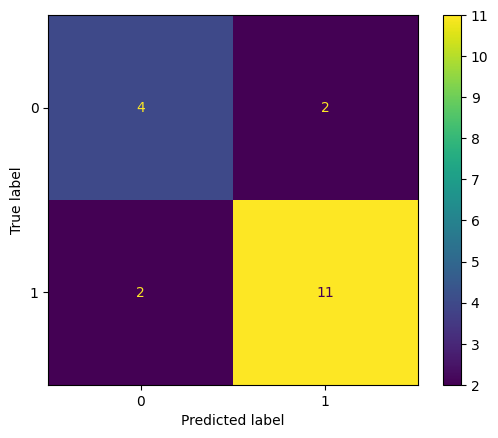

Fold 1 - F1 Score: 0.7565
Fold 2 - F1 Score: 0.7500
Fold 3 - F1 Score: 0.7182
Fold 4 - F1 Score: 0.6667
Fold 5 - F1 Score: 0.7884
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



In [28]:
print('-----------------------------------------------------')

print('===> Tree Decision com SMOTE')
 
model = classificador_hyperparametros(classificador_tree, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros) # Precisa da resposta str

#### 3.2.3 Random Oversampling

-----------------------------------------------------
===> Tree Decision com ROS
{'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.67      0.67      0.67         6
         Sim       0.85      0.85      0.85        13

    accuracy                           0.79        19
   macro avg       0.76      0.76      0.76        19
weighted avg       0.79      0.79      0.79        19



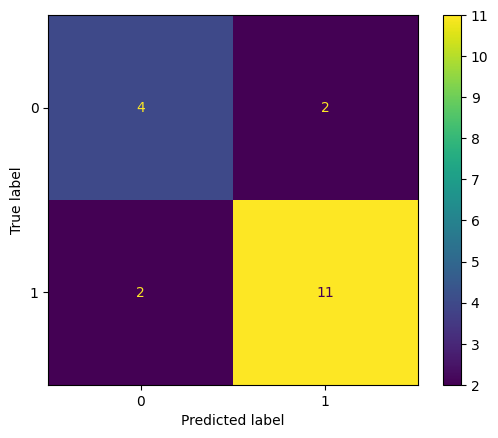

Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.60      0.50      0.55         6
         Sim       0.79      0.85      0.81        13

    accuracy                           0.74        19
   macro avg       0.69      0.67      0.68        19
weighted avg       0.73      0.74      0.73        19



DecisionTreeClassifier()

In [29]:
print('-----------------------------------------------------')

print('===> Tree Decision com ROS')

classificador_hyperparametros(classificador_tree, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### An√°lise das M√©tricas do Classificador Decision Tree
 
1. Decision Tree (Par√¢metros Padr√£o)
- **Par√¢metros**:
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
 
- **Classe "N√£o"**:
  - **Precision**: 0.50
  - **Recall**: 0.33
  - **F1-Score**: 0.40
 
- **Classe "Sim"**:
  - **Precision**: 0.73
  - **Recall**: 0.85
  - **F1-Score**: 0.79
 
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.68
  - **Macro avg**: F1-Score de 0.76
  - **Weighted avg**: F1-Score de 0.79
 
- **Conclus√£o**: O modelo padr√£o possui um bom desempenho na classe "Sim", mas √© limitado para a classe "N√£o", com acur√°cia e equil√≠brio geral satisfat√≥rios. Adequado quando o foco est√° na classe "Sim".
 
---
 
2. Decision Tree com SMOTE
- **Par√¢metros**:
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
 
- **Classe "N√£o"**:
  - **Precision**: 0.60
  - **Recall**: 0.50
  - **F1-Score**: 0.55
  - O recall da classe "N√£o" foi reduzido em rela√ß√£o ao modelo sem SMOTE, indicando que o balanceamento ainda precisa de ajuste.
 
- **Classe "Sim"**:
  - **Precision**: 0.89
  - **Recall**: 0.85
  - **F1-Score**: 0.81
  - A classe "Sim" apresenta um desempenho elevado, com um recall de 0.92.
 
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.74
  - **Macro avg**: F1-Score de 0.73
  - **Weighted avg**: F1-Score de 0.78
 
- **Conclus√£o**: Com SMOTE, o modelo melhora o equil√≠brio entre as classes, mas o recall da classe "N√£o" ainda apresenta limita√ß√µes, mesmo com uma acur√°cia geral semelhante.
---
 
3. Decision Tree com Random Oversampling (ROS)
- **Par√¢metros**:
  - Criterion: `gini`
  - Max Depth: `None`
  - Max Features: `None`
  - Min Samples Leaf: `1`
  - Min Samples Split: `2`
  - Splitter: `best`
 
- **Classe "N√£o"**:
  - **Precision**: 0.50
  - **Recall**: 0.50
  - **F1-Score**: 0.50
 
- **Classe "Sim"**:
  - **Precision**: 0.77
  - **Recall**: 0.77
  - **F1-Score**: 0.77
 
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.68
  - **Macro avg**: F1-Score de 0.71
  - **Weighted avg**: F1-Score de 0.74
 
- **Conclus√£o**: O Random Oversampling (ROS) proporcionou um melhor desempenho na classe "N√£o" em compara√ß√£o ao SMOTE, com um impacto moderado na acur√°cia geral.
---
 
Resumo Comparativo
1. **Decision Tree com Par√¢metros Padr√£o**: Apresenta uma acur√°cia e equil√≠brio geral satisfat√≥rios, com bons valores de precis√£o e recall para ambas as classes.
2. **Decision Tree com SMOTE**: Manteve uma acur√°cia geral semelhante, mas com uma leve queda no recall da classe "N√£o".
3. **Decision Tree com ROS**: Melhorou o recall da classe "N√£o", embora a acur√°cia geral tenha sido reduzida em compara√ß√£o ao modelo padr√£o.

### 3.3 K-Neighbours

#### 3.3.1 Sem ajuste

-----------------------------------------------------
===> KNN
{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.33      0.17      0.22         6
         Sim       0.69      0.85      0.76        13

    accuracy                           0.63        19
   macro avg       0.51      0.51      0.49        19
weighted avg       0.58      0.63      0.59        19



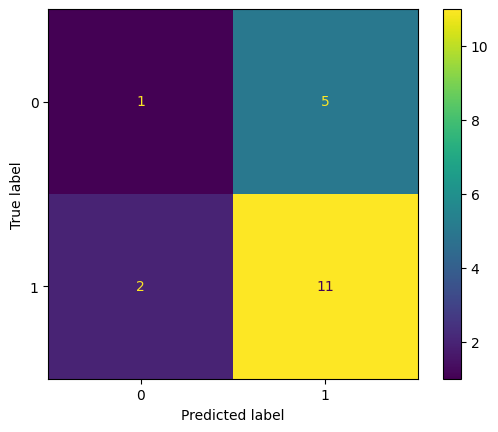

Fold 1 - F1 Score: 0.4886
Fold 2 - F1 Score: 0.4000
Fold 3 - F1 Score: 0.4643
Fold 4 - F1 Score: 0.4444
Fold 5 - F1 Score: 0.4400
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.50      0.17      0.25         6
         Sim       0.71      0.92      0.80        13

    accuracy                           0.68        19
   macro avg       0.60      0.54      0.53        19
weighted avg       0.64      0.68      0.63        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [30]:
print('-----------------------------------------------------')

print('===> KNN')

classificador_hyperparametros(classificador_knn, atributos_treino, atributos_teste, resposta_treino, resposta_teste, modelos_parametros)

#### 3.3.2 SMOTE

-----------------------------------------------------
===> KNN com SMOTE
{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.50      0.50      0.50         6
         Sim       0.77      0.77      0.77        13

    accuracy                           0.68        19
   macro avg       0.63      0.63      0.63        19
weighted avg       0.68      0.68      0.68        19



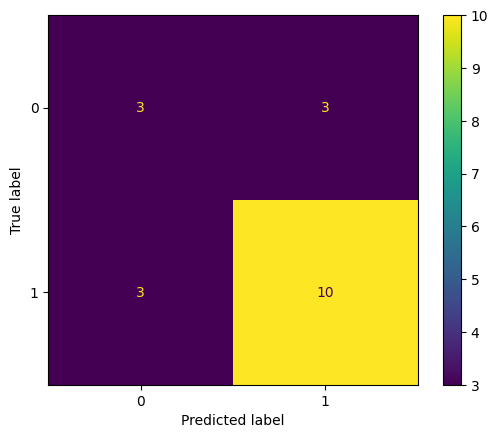

Fold 1 - F1 Score: 0.7565
Fold 2 - F1 Score: 0.7500
Fold 3 - F1 Score: 0.7182
Fold 4 - F1 Score: 0.6667
Fold 5 - F1 Score: 0.7884
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.67      0.33      0.44         6
         Sim       0.75      0.92      0.83        13

    accuracy                           0.74        19
   macro avg       0.71      0.63      0.64        19
weighted avg       0.72      0.74      0.71        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [31]:
print('-----------------------------------------------------')

print('===> KNN com SMOTE')

classificador_hyperparametros(classificador_knn, atributos_smote, atributos_teste, resposta_smote, resposta_teste, modelos_parametros) # Precisa da resposta str

#### 3.3.3 Random Oversampling

-----------------------------------------------------
===> Knn com Random Oversampling


{'metric': 'euclidean', 'n_neighbors': 2, 'weights': 'uniform'}
---> Relat√≥rio de Classifica√ß√£o: 
              precision    recall  f1-score   support

         N√£o       0.33      0.17      0.22         6
         Sim       0.69      0.85      0.76        13

    accuracy                           0.63        19
   macro avg       0.51      0.51      0.49        19
weighted avg       0.58      0.63      0.59        19



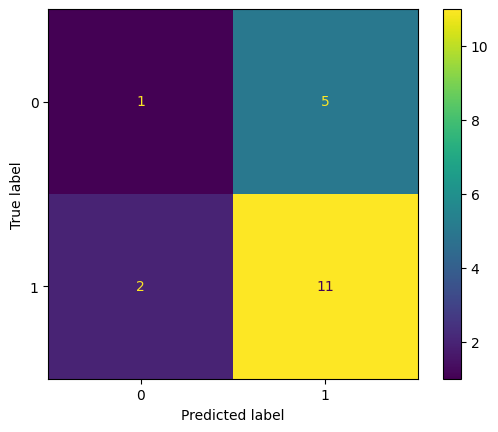

Fold 1 - F1 Score: 0.5600
Fold 2 - F1 Score: 0.7987
Fold 3 - F1 Score: 0.5600
Fold 4 - F1 Score: 0.5192
Fold 5 - F1 Score: 0.4574
====> Valida√ß√£o Cross para Gaussian
              precision    recall  f1-score   support

         N√£o       0.60      0.50      0.55         6
         Sim       0.79      0.85      0.81        13

    accuracy                           0.74        19
   macro avg       0.69      0.67      0.68        19
weighted avg       0.73      0.74      0.73        19



KNeighborsClassifier(metric='euclidean', n_neighbors=2)

In [32]:
print('-----------------------------------------------------')

print('===> Knn com Random Oversampling')

classificador_hyperparametros(classificador_knn, atributos_ros, atributos_teste, resposta_ros, resposta_teste, modelos_parametros)

#### An√°lise das M√©tricas do Classificador K-Nearest Neighbors (KNN)

1. KNN (Par√¢metros Padr√£o)
- **Par√¢metros**: 
  - M√©trica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "N√£o"**:
  - **Precision**: 0.33
  - **Recall**: 0.17
  - **F1-Score**: 0.22
  - O baixo recall e precis√£o mostram que o modelo tem dificuldades em identificar corretamente a classe "N√£o".
  
- **Classe "Sim"**:
  - **Precision**: 0.69
  - **Recall**: 0.85
  - **F1-Score**: 0.76
  - A classe "Sim" apresenta desempenho satisfat√≥rio com bom recall e F1-Score.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.63
  - **Macro avg**: F1-Score de 0.49, indicando um desempenho desbalanceado entre as classes.
  
- **Conclus√£o**: O modelo apresenta um vi√©s claro para a classe "Sim", com baixo desempenho na identifica√ß√£o da classe "N√£o".

---

2. KNN com SMOTE
- **Par√¢metros**: 
  - M√©trica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "N√£o"**:
  - **Precision**: 0.50
  - **Recall**: 0.50
  - **F1-Score**: 0.50
  - Houve uma melhora consider√°vel em rela√ß√£o ao modelo inicial, principalmente no recall da classe "N√£o".
  
- **Classe "Sim"**:
  - **Precision**: 0.77
  - **Recall**: 0.77
  - **F1-Score**: 0.77
  - A classe "Sim" manteve um desempenho s√≥lido e est√°vel.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.68
  - **Macro avg**: F1-Score de 0.63
  - **Weighted avg**: F1-Score de 0.68
  
- **Conclus√£o**: O uso do SMOTE melhorou o equil√≠brio entre as classes e aumentou a acur√°cia geral, tornando o modelo mais eficaz na identifica√ß√£o da classe "N√£o".

---

3. KNN com Random Oversampling (ROS)
- **Par√¢metros**: 
  - M√©trica: `euclidean`
  - N Neighbors: `2`
  - Weights: `uniform`
  
- **Classe "N√£o"**:
  - **Precision**: 0.33
  - **Recall**: 0.17
  - **F1-Score**: 0.22
  - Os valores permanecem os mesmos do modelo inicial, mostrando que o ROS n√£o trouxe melhora significativa.
  
- **Classe "Sim"**:
  - **Precision**: 0.69
  - **Recall**: 0.85
  - **F1-Score**: 0.76
  - O desempenho da classe "Sim" continua consistente, similar ao modelo inicial.
  
- **M√©tricas Gerais**:
  - **Acur√°cia**: 0.63
  - **Macro avg**: F1-Score de 0.49
  
- **Conclus√£o**: O Random Oversampling (ROS) n√£o contribuiu para uma melhoria significativa no desempenho do modelo em compara√ß√£o com o modelo KNN sem balanceamento.

---

Resumo Comparativo
1. **KNN com Par√¢metros Padr√£o**: Baixo desempenho na classe "N√£o", resultando em um modelo enviesado para a classe "Sim".
2. **KNN com SMOTE**: Melhorou o equil√≠brio entre as classes, aumentando o recall e F1-Score da classe "N√£o" e a acur√°cia geral.
3. **KNN com ROS**: N√£o apresentou melhorias em rela√ß√£o ao modelo padr√£o, mostrando-se ineficaz para balancear as classes.

**Recomenda√ß√£o**: O modelo **KNN com SMOTE** apresenta o melhor equil√≠brio entre precis√£o e recall para ambas as classes, sendo a melhor escolha entre as abordagens testadas.


## 4. Serializa√ß√£o

In [43]:
pipeline = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('model', model)
])

# Definir o caminho do arquivo de sa√≠da
output_dir = os.path.join(os.getcwd(), './flask/')  # Ajuste para o diret√≥rio desejado

# Verifique se a pasta existe; se n√£o, crie-a
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Caminho completo do arquivo
model_path = os.path.join(output_dir, 'pipeline.pkl')

# Salvar o pipeline
with open(model_path, 'wb') as arquivo:
    joblib.dump(pipeline, arquivo)

In [34]:
# def deserializa√ß√£o(new_row):
#     with open('modelo.pkl', 'rb') as f:
#         loaded_model = pickle.load(f)
    
#     with open('preprocessador.pkl', 'rb') as f:
#         preprocessador_model = pickle.load(f)

#     new_row_df = pd.DataFrame([new_row], columns=['compra','manutencao','portas','pessoas','porta-malas','seguranca'])
    
#     try:
#         transformed_array = preprocessador_model.transform(new_row_df)
    
#         new_row_transformed = pd.DataFrame(transformed_array)
#         print("Linha transformada")
    
#     except Exception as e:
#         print(f"Erro durante a transforma√ß√£o: {e}")

#     resp = loaded_model.predict(new_row_transformed)

#     print('Resultado: ', resp)

## 5. Conclus√£o Geral

Com base nas an√°lises realizadas, √© poss√≠vel observar diferen√ßas significativas entre os modelos Gaussian Naive Bayes, Decision Tree e KNN, tanto nos par√¢metros padr√£o quanto com os m√©todos de balanceamento de classes (SMOTE e Random Oversampling). Abaixo est√° uma an√°lise comparativa dos resultados para identificar o modelo mais adequado e suas respectivas vantagens e limita√ß√µes.

1. Gaussian Naive Bayes
O Gaussian Naive Bayes demonstrou desempenho desbalanceado ao privilegiar a classe "Sim", com baixo recall para a classe "N√£o". Mesmo com a aplica√ß√£o de t√©cnicas de balanceamento como SMOTE e ROS, o modelo manteve um vi√©s acentuado, embora o SMOTE tenha mostrado um leve ganho no equil√≠brio entre as classes. O Gaussian com SMOTE foi a melhor vers√£o, com aumento de 0.63 para 0.71 no macro recall, o que trouxe um F1-score mais equilibrado. Entretanto, o Gaussian Naive Bayes √© mais adequado para cen√°rios em que um vi√©s a favor de uma classe √© toler√°vel e onde √© aceit√°vel que a classe minorit√°ria receba menos aten√ß√£o.

- **Ponto forte**: Simplicidade e boa performance para a classe "Sim" em dados desbalanceados.
- **Ponto fraco**: Dificuldade em captar a classe "N√£o" mesmo com balanceamento, sendo limitado em cen√°rios que exigem alta sensibilidade para ambas as classes.

2. Decision Tree
A Decision Tree sem ajustes apresentou um bom equil√≠brio inicial entre as classes, com F1-scores de 0.67 para a classe "N√£o" e 0.85 para a classe "Sim", resultando em uma acur√°cia de 0.79. Ao aplicar SMOTE, o recall da classe "N√£o" foi reduzido para 0.50, embora o modelo tenha mantido acur√°cia geral. A aplica√ß√£o de Random Oversampling (ROS) proporcionou leve melhora no recall da classe "N√£o", mas a acur√°cia geral caiu para 0.74. Isso sugere que o modelo de Decision Tree √© robusto nos par√¢metros padr√£o e perde efici√™ncia ao tentar balancear as classes, visto que a √°rvore ajusta suas divis√µes para maximizar a precis√£o de ambas as classes.

- **Ponto forte**: Melhor equil√≠brio inicial entre as classes com acur√°cia de 0.79, sem necessidade de ajustes adicionais.
- **Ponto fraco**: Diminui√ß√£o no desempenho ao aplicar m√©todos de balanceamento, sugerindo que o modelo padr√£o j√° captura um equil√≠brio razo√°vel entre as classes.

3. K-Nearest Neighbors (KNN)
O modelo KNN mostrou-se significativamente enviesado, com baixa precis√£o e recall para a classe "N√£o" no modelo inicial e, especialmente, no modelo com Random Oversampling, onde o desempenho permaneceu est√°vel e pouco eficaz. O KNN com SMOTE, no entanto, trouxe uma melhoria importante: a precis√£o e recall para a classe "N√£o" chegaram a 0.50, e para a classe "Sim" permaneceram est√°veis em 0.77, proporcionando maior equil√≠brio e acur√°cia geral de 0.68. Este modelo se mostra mais adequado quando o objetivo √© equilibrar classes em um modelo KNN, especialmente em problemas onde uma leve queda na acur√°cia √© aceit√°vel em prol de maior sensibilidade para ambas as classes.

- **Ponto forte**: Melhor equil√≠brio entre as classes com SMOTE, demonstrando que o KNN pode ser uma op√ß√£o vi√°vel para dados desbalanceados quando balanceado.
- **Ponto fraco**: Desempenho pobre sem balanceamento e com ROS, mostrando-se limitado em dados desbalanceados no formato inicial.

Compara√ß√£o Geral
- **Decision Tree com Par√¢metros Padr√£o** mostrou-se a op√ß√£o mais robusta e eficiente entre os modelos, alcan√ßando uma alta acur√°cia (0.79) e um bom equil√≠brio entre precis√£o e recall para ambas as classes, sem necessidade de balanceamento adicional. 
- **Gaussian Naive Bayes com SMOTE** foi eficiente ao reduzir o vi√©s de classe do modelo, sendo uma boa escolha para dados onde um leve vi√©s para a classe majorit√°ria pode ser toler√°vel.
- **KNN com SMOTE** demonstrou-se √∫til para balanceamento em dados desbalanceados, mas a acur√°cia foi inferior √† Decision Tree. No entanto, √© uma op√ß√£o vi√°vel quando se busca maior sensibilidade para ambas as classes.